<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import numpy as np
import pandas as pd

In [146]:
 # Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L = 1.5  # Давление в линии нефтесбора

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 3  # устьевого штуцера
r_GU = 3  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
q_0 = 90  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]
lambda_2 = [0.5, 0.82, 0.74]
lambda_3 = [0.42, 0.18, 0.3]


S_t = 0.01  # Площадь поперечного сечени НКТ
T_2 = 0.4  # Постоянна времени притока

In [147]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
_q_L = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
___p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []
_betta_G3 = []
_betta_GN = []
_N_1 = []
_N_2 = []
_count = []
_n_NN = []
___q = []

In [148]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_1 = 0.083
r_2 = 0.017
r_R = 0.1

In [149]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [150]:
# Высота столба жидкости
gamma = (1-betta)*gamma_oil+betta*gamma_water
dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [151]:
h_0 = q_0*(r_U + r_N + r_K + r_R/gamma) - dH_R
h_0 = 2300

In [152]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
M_R3 = 0.16
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = 0.0000091 #k_S*X_G*M_R3

In [153]:
# Расчёт динамики

# Начальные условия

M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 90
q_L = 90.169552
_q = 90
p_3 = p_L + gamma * h_4

# Если запсукаем не из нуля
p_1 = 12.63
p_2 = 20.116
p_3 = 4.207
p_4 = 1.532
h_4 = 331

epsilon = 0.00001 * p_3


# Сегмент напорной характеристики
i = 1
k = 35000
dt = 0.0001

# Статика при вариации частоты
_N_1 = []
_N_2 = []
_count = []
_n_NN = []


In [154]:
# Начало расчёта
for _k in range(k):
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
    p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
    __p_3 = p_4 + gamma * h_4
    # Балансировка притока по начальным условиям
    while abs(p_3 - __p_3) > epsilon:
        p_3 = (1-M_q)*p_3 + M_q*__p_3
        q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
        p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
        __p_3 = p_4 + gamma * h_4
    p_3 = __p_3
    p_8 =p_L + gamma*r_U*q_L

    if _k == 0:
      _q = q

    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
    q_N = max(q_N, 0)

    if i > 0 and q_N > w*q_0*q_Pump[i]:
      i-=1
      i = max(i, 0)
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)

    if i < 2 and  q_N < w*q_0*q_Pump[i+1]:
      i+=1
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)




    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))


    p_1 = p_2 - r_1*q
    p_5 = p_8 + gamma*(H_N+r_N*q_N)


    h_N = h_0*(w*w*lambda_0[i]-w*lambda_1[i]*(q_N/q_0))
    n_N = 0.5
    N_1_0 = (gamma*h_0*q_0)/n_N
    N_2 = gamma * h_N * q_N
    alpha_n_L =0.1
    alpha_n_R =0.07
    w_n_L = 0.96
    w_n_R = 1.04
    delta_n_N = alpha_n_L * max(w_n_L-w, 0) + alpha_n_R * max(w-w_n_R, 0)
    N_1 = N_1_0*(1+delta_n_N)*(w*w*w*lambda_2[i] + w*w*lambda_3[i]*(q_N/q_0))
    n_NN = N_2/N_1

    _p_1.append(p_1)
    _p_3.append(p_3)
    _p_4.append(p_4)
    _p_8.append(p_8)
    _q_N.append(q_N)
    __q.append(q)
    _q_L.append(q_L)
    _h_4.append(h_4)
    _u.append(w)
    _p_5.append(p_5)
    _N_1.append(N_1)
    _N_2.append(N_2)
    _n_NN.append(n_NN)
    _betta_G3.append(betta_G3)
    _betta_GN.append(betta_GN)
    ___q.append(_q)

    ___p_3.append(p_1-gamma*(H_R-H_N+r_K*q))

    # Шаг по Эйлеру
    p_2 = p_2 + (dt/T_2)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (dt/S_t)*(q-q_N)
    q_L = q_N  # q_L + (dt/0.005)*(q_N-q_L)
    _q = _q + (dt/T_2)*(q-_q)

    if _k * dt == 0.2:
      w = 1.16
    if _k * dt == 1.5:
      w = 0.82
    if _k * dt == 2.5:
      w = 1.116
    if _k * dt == 3:
      w = 1

In [155]:

x = np.linspace(0, k*dt, k)
x

array([0.00000000e+00, 1.00002857e-04, 2.00005714e-04, ...,
       3.49979999e+00, 3.49990000e+00, 3.50000000e+00])

In [156]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u, 'x': x,
                   'p_4': _p_4, 'p_8': _p_8, 'p_5': _p_5, 'N_1': _N_1, 'N_2': _N_2, 'n_NN': _n_NN,
                   'betta_G3': _betta_G3, 'betta_GN': _betta_GN, 'q_L': _q_L, '_q': ___q, '___p_3': ___p_3})

In [157]:
df

,q_N,p_3,p_1,q,h_4,u,x,p_4,p_8,p_5,N_1,N_2,n_NN,betta_G3,betta_GN,q_L,_q,___p_3
0,90.152342,4.200190,12.623985,90.265245,331.000000,1.0,0.0000,1.532330,3.680300,22.706811,3337.856681,1668.415220,0.499846,0.434616,0.130385,90.169552,90.265245,4.200216
1,90.154128,4.200200,12.623960,90.265536,331.001129,1.0,0.0001,1.532330,3.679884,22.706453,3337.868599,1668.415107,0.499844,0.434615,0.130384,90.152342,90.265245,4.200190
2,90.153984,4.200208,12.623969,90.265428,331.002243,1.0,0.0002,1.532330,3.679927,22.706491,3337.867639,1668.415116,0.499845,0.434614,0.130384,90.154128,90.265245,4.200200
3,90.154036,4.200217,12.623978,90.265324,331.003358,1.0,0.0003,1.532330,3.679923,22.706489,3337.867986,1668.415113,0.499845,0.434613,0.130384,90.153984,90.265245,4.200208
4,90.154068,4.200226,12.623986,90.265220,331.004470,1.0,0.0004,1.532330,3.679925,22.706492,3337.868201,1668.415111,0.499845,0.434612,0.130384,90.154036,90.265245,4.200217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,90.040685,4.170475,12.593936,90.191950,327.307346,1.0,3.4996,1.532377,3.677183,22.700094,3337.111518,1668.419659,0.499959,0.438167,0.131450,90.040639,92.360726,4.170462
34996,90.040731,4.170487,12.593948,90.191916,327.308858,1.0,3.4997,1.532377,3.677184,22.700097,3337.111827,1668.419658,0.499959,0.438165,0.131450,90.040685,92.360184,4.170475
34997,90.040778,4.170499,12.593960,90.191882,327.310370,1.0,3.4998,1.532377,3.677185,22.700100,3337.112136,1668.419657,0.499959,0.438164,0.131449,90.040731,92.359642,4.170487
34998,90.040824,4.170511,12.593972,90.191848,327.311881,1.0,3.4999,1.532377,3.677186,22.700102,3337.112445,1668.419657,0.499959,0.438162,0.131449,90.040778,92.359100,4.170499


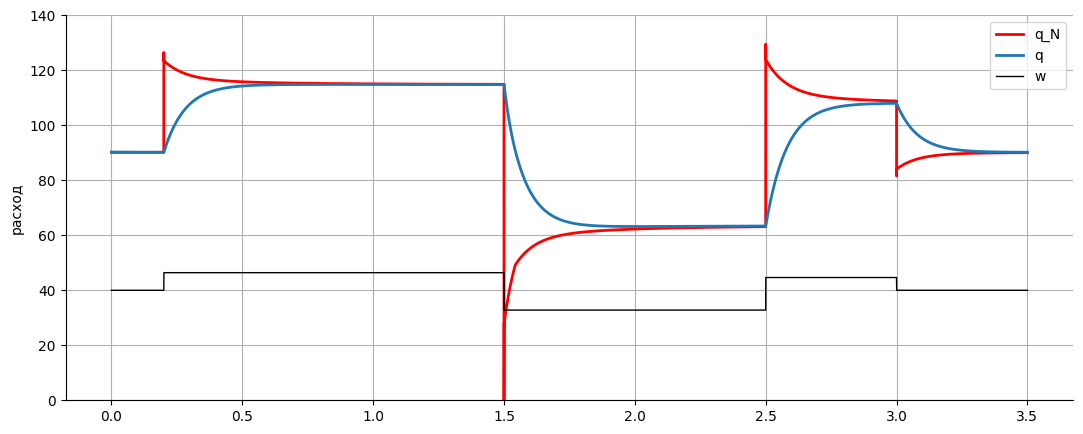

In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

plt.plot(df['x'], df['q_N'], 'r', lw=2, label='q_N')
plt.plot(df['x'], df['q'], lw=2, label='q')
# plt.plot(df['x'], df['q_L'], 'k--', lw=1, label='q_L')
plt.plot(df['x'], df['u']*40, 'k', lw=1, label='w')

# plt.plot(df['x'], [df['q'][k-1]]*k,'r--', lw=1)
# plt.annotate(df['q_N'][k-1].round(1), xy = (df['x'][100], df['q_N'][k-1]*1.03 ))

plt.legend()



# set x label
plt.ylabel('расход')


plt.ylim(0, 140)
plt.grid(True)



# display plot
plt.show()


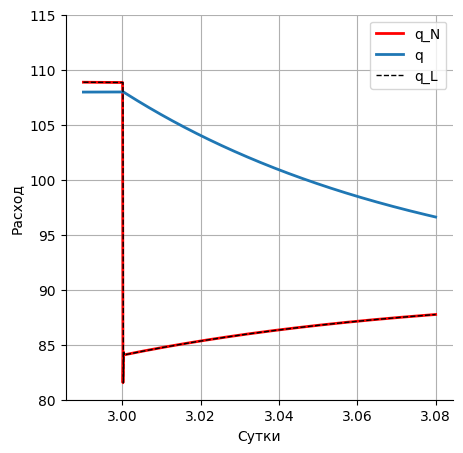

In [159]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

plt.plot(df['x'][29900:30800], df['q_N'][29900:30800], 'r', lw=2, label='q_N')
plt.plot(df['x'][29900:30800], df['q'][29900:30800], lw=2, label='q')
plt.plot(df['x'][29900:30800], df['q_L'][29900:30800], 'k--', lw=1, label='q_L')



# set x label
plt.xlabel('Сутки')
plt.ylabel('Расход')


plt.ylim(80, 115)
plt.grid(True)

plt.legend()

# display plot
plt.show()

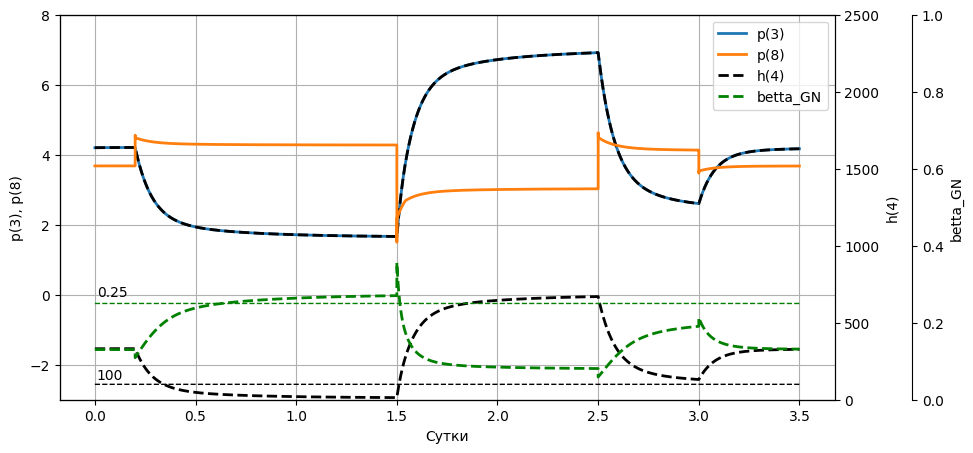

In [160]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.1))

p1, = ax.plot(df['x'], df['p_3'], lw=2, label="p(3)")
p11, = ax.plot(df['x'], df['___p_3'],'k--', lw=2, label="p(33)")
p2, = ax.plot(df['x'], df['p_8'], lw=2, label="p(8)")

p3, = twin1.plot(df['x'],  df['h_4'],'k--', lw=2, label="h(4)")

p4, = twin1.plot(df['x'],  [h_lim]*k,'k--', lw=1)
twin1.annotate(h_lim, xy = (df['x'][100], h_lim*1.3 ))

p5, = twin2.plot(df['x'],  df['betta_GN'],'g--', lw=2, label="betta_GN")
p6, = twin2.plot(df['x'],  [betta_G_lim]*k,'g--', lw=1)
twin2.annotate(betta_G_lim, xy = (df['x'][100], betta_G_lim*1.08 ))


ax.set(ylim=(-3, 8), xlabel="Сутки", ylabel="p(3), p(8)")
twin1.set(ylim=(0, 2500), ylabel="h(4)")
twin2.set(ylim=(0, 1), ylabel="betta_GN")

ax.legend(handles=[p1, p2, p3,p5])
ax.grid()
plt.show()

In [161]:
df.iloc[14999:15002]

,q_N,p_3,p_1,q,h_4,u,x,p_4,p_8,p_5,N_1,N_2,n_NN,betta_G3,betta_GN,q_L,_q,___p_3
14999,114.891869,1.664333,10.187105,114.830538,13.830537,1.16,1.499943,1.552859,4.278086,24.102200,5347.220776,2577.928390,0.482106,1.098290,0.270264,114.891885,113.645411,1.664338
15000,114.891852,1.664328,10.187100,114.830537,13.829923,1.16,1.500043,1.552859,4.278085,24.102199,5347.220625,2577.928474,0.482106,1.098293,0.270265,114.891869,113.645707,1.664333
15001,0.000000,1.655967,10.179151,114.926249,13.829310,0.82,1.500143,1.544503,4.278085,20.398085,1380.532435,0.000000,0.000000,0.973843,0.356546,114.891852,113.646003,1.655998


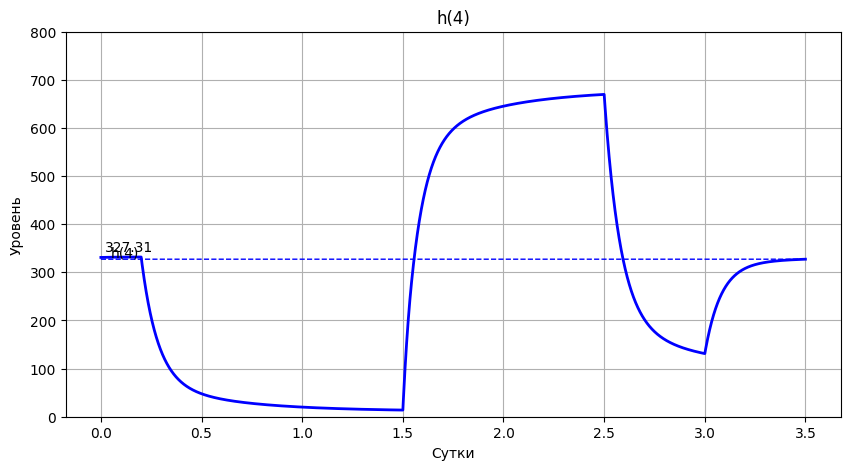

In [162]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(df['x'], df['h_4'],'b', lw=2)
plt.plot(df['x'], [df['h_4'][k-1]]*k,'b--', lw=1)

plt.annotate('h(4)', xy = (df['x'][500],df['h_4'][200] ))
plt.annotate(str(df['h_4'][k-1].round(2)), xy = (df['x'][200], df['h_4'][k-1]*1.05))

# set x label
plt.xlabel('Сутки')
plt.ylabel('Уровень')

# set title
plt.title('h(4)')
plt.ylim(0, 800)
plt.grid(True)
plt.show()

In [163]:
# Идентификация

from dataclasses import dataclass, field
from typing import List

@dataclass
class CalculatedValues:
  values: List[float] = field(default_factory=list)

  def add(self, element):
    self.values.append(element)


calc_q = CalculatedValues()
calc__q = CalculatedValues()
calc_q_N = CalculatedValues()
calc_dp = CalculatedValues()
calc_dp_3 = CalculatedValues()
calc_dp_4 = CalculatedValues()
calc_y = CalculatedValues()

for _k in range(k-1):
  q_N = (1/(gamma*r_U))*(_p_8[_k]-p_L)

  dp_3 = (1/dt)*(_p_3[_k+1]-_p_3[_k])
  dp_4 = (1/dt)*(_p_4[_k+1]-_p_4[_k])
  dp = dp_3 - dp_4

  q = q_N + ((S_t/gamma) * dp)

  if _k == 0:
    _q = q
  else:
    _q = _q + (dt/T_2)*(q - _q)

  y = _p_3[_k] + gamma*(H_R-H_N+r_K*q)

  calc_q_N.add(q_N)
  calc_q.add(q)
  calc__q.add(_q)
  calc_dp.add(dp)
  calc_dp_3.add(dp_3)
  calc_dp_4.add(dp_4)
  calc_y.add(y)

calc_df = pd.DataFrame({'q_N': calc_q_N.values, 'q': calc_q.values, '_q': calc__q.values, 'dp': calc_dp.values, 'dp_3': calc_dp_3.values, 'dp_4': calc_dp_4.values, 'y': calc_y.values})


In [164]:
calc_df

,q_N,q,_q,dp,dp_3,dp_4,y
0,90.169552,90.282455,90.282455,0.091000,0.092666,0.001666,12.624029
1,90.152342,90.263750,90.282451,0.089795,0.089180,-0.000615,12.623962
2,90.154128,90.265571,90.282446,0.089824,0.089232,-0.000592,12.623979
3,90.153984,90.265272,90.282442,0.089698,0.089106,-0.000592,12.623986
4,90.154036,90.265188,90.282438,0.089588,0.088997,-0.000592,12.623995
...,...,...,...,...,...,...,...
34994,90.040592,90.191937,92.361187,0.121984,0.121563,-0.000421,12.593936
34995,90.040639,90.191903,92.360645,0.121919,0.121499,-0.000421,12.593948
34996,90.040685,90.191869,92.360102,0.121855,0.121434,-0.000420,12.593960
34997,90.040731,90.191836,92.359560,0.121790,0.121370,-0.000420,12.593972


In [165]:
sum(calc_q.values)

3291595.172159162

In [166]:
# формируем и заполняем матрицу размерностью 2x2
A = np.empty((3, 3))
A[[0], [0]] = k-1
A[[0], [1]] = sum(calc_q.values)
A[[0], [2]] = sum(calc__q.values)

A[[1], [0]] = sum(calc_q.values)
A[[1], [1]] = sum([value**2 for value in calc_q.values])
A[[1], [2]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(k-1)])

A[[2], [0]] = sum(calc__q.values)
A[[2], [1]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(k-1)])
A[[2], [2]] = sum([value**2 for value in calc__q.values])
A


array([[3.49990000e+04, 3.29159517e+06, 3.28329100e+06],
       [3.29159517e+06, 3.23737558e+08, 3.15376925e+08],
       [3.28329100e+06, 3.15376925e+08, 3.14617631e+08]])

In [167]:
# находим обратную матрицу
A = np.linalg.inv(A)
# формируем и заполняем матрицу размерностью 3x1
C = np.empty((3, 1))
C[0] = sum(calc_y.values)
C[1] = sum([calc_y.values[i]*calc_q.values[i] for i in range(k-1)])
C[2] = sum([calc_y.values[i]*calc__q.values[i] for i in range(k-1)])
C


array([[  428713.23318628],
       [39033947.4931156 ],
       [39559000.57805797]])

In [168]:
# умножаем матрицу на вектор
ww = np.dot(A, C)
ww

array([[ 2.16466626e+01],
       [-8.27365532e-02],
       [-1.72275539e-02]])

In [169]:
import scipy
X = np.array([[1 for _ in range(k-1)],
              calc_q.values,
              calc__q.values]).T
y = np.array([calc_y.values]).T
b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
print(b)

[[ 2.16466626e+01]
 [-8.27365532e-02]
 [-1.72275539e-02]]


In [170]:
A

array([[ 1.36023397e-03, -6.80745529e-08, -1.41269096e-05],
       [-6.80745529e-08,  1.31590886e-07, -1.31198052e-07],
       [-1.41269096e-05, -1.31198052e-07,  2.82118942e-07]])

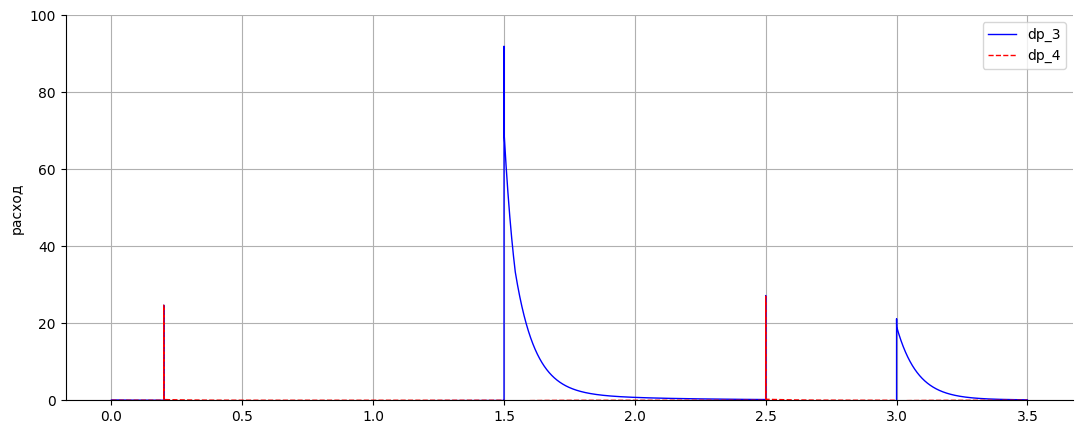

In [171]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

#plt.plot(df['x'][:k-1], df['q_N'][:k-1], 'r', lw=2, label='q_N')
#plt.plot(df['x'][:k-1], df['q'][:k-1], lw=2, label='q')

#plt.plot(df['x'][:k-1], calc_df['q_N'], 'k--', lw=1, label='q_N')
#plt.plot(df['x'][:k-1], calc_df['q'][:k-1], 'r--', lw=1, label='q')

plt.plot(df['x'][:k-1], calc_df['dp_3'][:k-1], 'b', lw=1, label='dp_3')

plt.plot(df['x'][:k-1], calc_df['dp_4'][:k-1], 'r--', lw=1, label='dp_4')
#plt.plot(df['x'], df['u']*40, 'k', lw=1, label='w')



plt.legend()



# set x label
plt.ylabel('расход')


plt.ylim(0, 100)
plt.grid(True)



# display plot
plt.show()

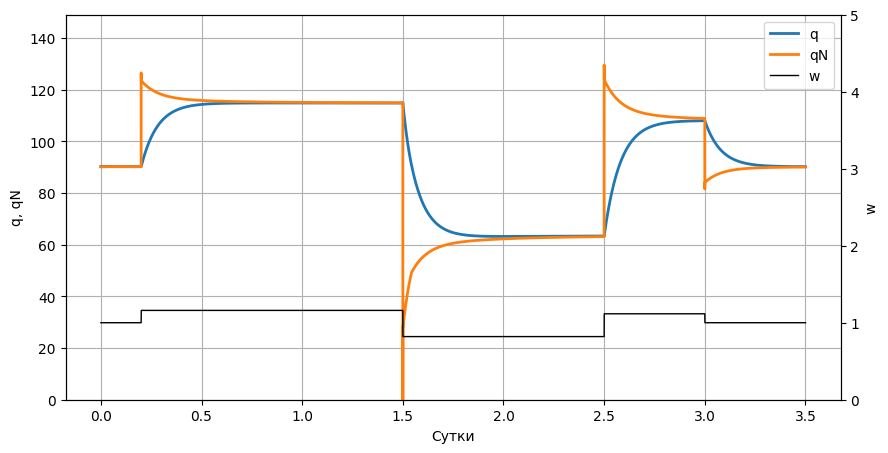

In [172]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df['x'], df['q'], lw=2, label="q")
p2, = ax.plot(df['x'], df['q_N'], lw=2, label="qN")

p3, = twin1.plot(df['x'],  df['u'],'k', lw=1, label="w")


ax.set(ylim=(0, 149), xlabel="Сутки", ylabel="q, qN")
twin1.set(ylim=(0, 5), ylabel="w")

ax.legend(handles=[p1, p2, p3])
ax.grid()
plt.show()

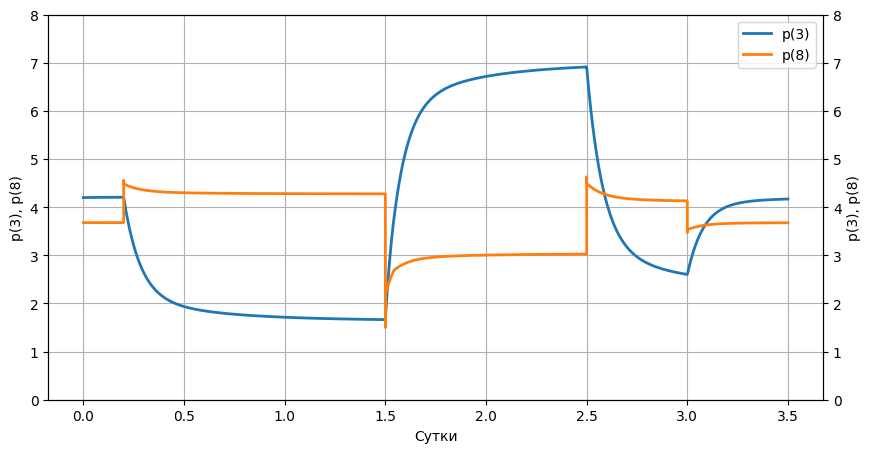

In [173]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df['x'], df['p_3'], lw=2, label="p(3)")
p2, = ax.plot(df['x'], df['p_8'], lw=2, label="p(8)")

ax.set(ylim=(0, 8), xlabel="Сутки", ylabel="p(3), p(8)")
twin1.set(ylim=(0, 8), ylabel="p(3), p(8)")

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

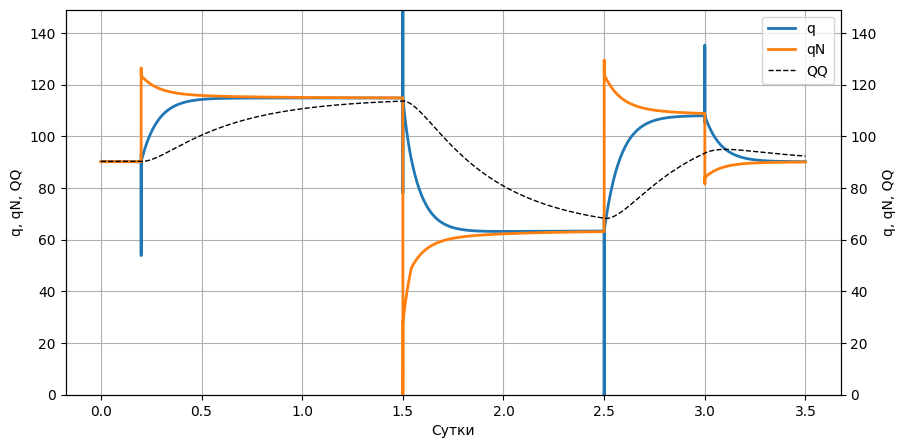

In [174]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df['x'][:k-1], calc_df['q'][:k-1], lw=2, label="q")
p2, = ax.plot(df['x'][:k-1], calc_df['q_N'][:k-1], lw=2, label="qN")
p3, = ax.plot(df['x'][:k-1], calc_df['_q'][:k-1], 'k--', lw=1, label="QQ")


ax.set(ylim=(0, 149), xlabel="Сутки", ylabel="q, qN, QQ")
twin1.set(ylim=(0, 149), ylabel="q, qN, QQ")

ax.legend(handles=[p1, p2, p3])
ax.grid()
plt.show()

In [175]:
calc_df['q']

,q
0,90.282455
1,90.263750
2,90.265571
3,90.265272
4,90.265188
...,...
34994,90.191937
34995,90.191903
34996,90.191869
34997,90.191836
